In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [32]:
ast1 = 'AME'
ast2 = 'IEX'
tickers = [ast1, ast2]
data = yf.download(tickers, start='2020-01-01', end='2025-01-01')['Close']
data.dropna(inplace=True)

C:\Users\Gokul\AppData\Local\Temp\ipykernel_17032\1267481865.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  2 of 2 completed


In [33]:
# Independent variable
X = data[ast2]
X = sm.add_constant(X)  # Adds intercept (alpha) term

# Dependent variable
y = data[ast1]

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Predicted AAPL based on MSFT
y_pred = model.predict(X)

# Residual spread (mean-reverting series)
spread = y - y_pred

In [34]:
from statsmodels.tsa.stattools import adfuller

# Test if spread is stationary
adf_result = adfuller(spread)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Residual is stationary (mean-reverting)")
else:
    print("Residual is NOT stationary")

ADF Statistic: -0.8679233883842173
p-value: 0.7983521330276576
Residual is NOT stationary


In [35]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    AME   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2520.
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.81e-302
Time:                        23:41:30   Log-Likelihood:                -5290.1
No. Observations:                1258   AIC:                         1.058e+04
Df Residuals:                    1256   BIC:                         1.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.3889      3.681    -13.689      0.0

In [36]:
spread_series = pd.Series(spread, index=data.index)

zscore = (spread_series - spread_series.rolling(20).mean()) / spread_series.rolling(20).std()

In [37]:
long = zscore < -1
short = zscore > 1
exit = zscore.abs() < 0.2

In [38]:
positions = pd.DataFrame(index=data.index)
positions[ast1] = 0
positions[ast2] = 0

positions.loc[long, ast1] = 1
positions.loc[long, ast2] = -model.params[1]  # scale hedge ratio

positions.loc[short, ast1] = -1
positions.loc[short, ast2] = model.params[1]

positions[exit] = 0
positions.fillna(method='ffill', inplace=True)

returns = data.pct_change()
strategy_returns = (positions.shift(1) * returns).sum(axis=1)
cumulative_returns = (1 + strategy_returns).cumprod()

C:\Users\Gokul\AppData\Local\Temp\ipykernel_17032\1488938693.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positions.loc[long, ast2] = -model.params[1]  # scale hedge ratio
C:\Users\Gokul\AppData\Local\Temp\ipykernel_17032\1488938693.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.9344511774553189' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  positions.loc[long, ast2] = -model.params[1]  # scale hedge ratio
C:\Users\Gokul\AppData\Local\Temp\ipykernel_17032\1488938693.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

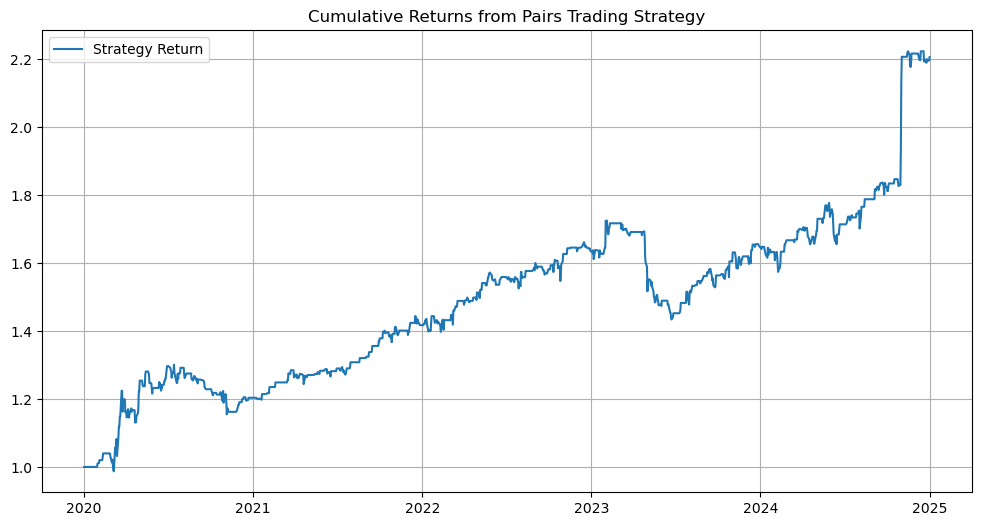

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Strategy Return")
plt.title("Cumulative Returns from Pairs Trading Strategy")
plt.grid(True)
plt.legend()
plt.show()

In [40]:
def sharpe_ratio(returns, risk_free=0.0):
    excess = returns - risk_free
    return np.sqrt(252) * (excess.mean() / excess.std())

print("Sharpe Ratio:", sharpe_ratio(strategy_returns))
print("Max Drawdown:", (cumulative_returns / cumulative_returns.cummax() - 1).min())

Sharpe Ratio: 1.2026658106166621
Max Drawdown: -0.16875768276205827
